In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from geo_tool import Point_Cloud

import tf_lab.autopredictors.scripts.minhyuk_data as minhyuk_data
from tf_lab.autopredictors.scripts.minhyuk_data import KinectData
from tf_lab.autopredictors.evaluate import accuracy_of_completion, coverage_of_completion

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.in_out import PointCloudDataSet

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import unpickle_data

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
incomplete_n_samples = 2048
complete_n_samples = 4096
normalize_data = True
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
category_name = 'coseg_chairs'  # assembly_chairs coseg_chairs  airplanes shapenet_tables
ae_loss = 'chamfer'
ae_type = 'chair' # normally this should match the predicted class

In [46]:
gt_pclouds, gt_names = minhyuk_data.groundtruth_point_clouds(category_name, complete_n_samples)
m_completions, gt_names_2 = minhyuk_data.minhyuk_completions(category_name, complete_n_samples)
partial_pclouds, gt_names_3 = minhyuk_data.incomplete_point_clouds(category_name, incomplete_n_samples)

assert(np.alltrue(gt_names == gt_names_2))
assert(np.alltrue(gt_names == gt_names_3))

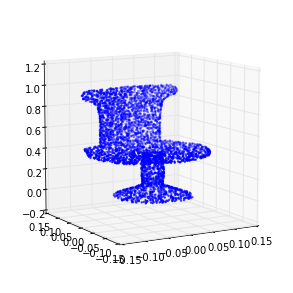

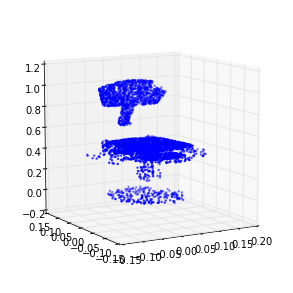

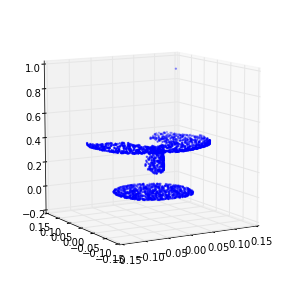

In [47]:
# RUN to see gt-completion-partial triplets are aligned.
rid = np.random.randint(len(gt_pclouds))
Point_Cloud(gt_pclouds[rid]).plot();
Point_Cloud(m_completions[rid]).plot();
Point_Cloud(partial_pclouds[rid]).plot();

In [48]:
rot_degrees = minhyuk_data.rotation_degrees[category_name]

if normalize_data:
    _, partial_pclouds_tr = minhyuk_data.normalize_point_clouds(gt_pclouds, partial_pclouds, rot_degrees)    
    gt_pclouds_tr, m_completions_tr = minhyuk_data.normalize_point_clouds(gt_pclouds, m_completions, rot_degrees)

# if normalize_data:
#     _, partial_pclouds = minhyuk_data.normalize_point_clouds(gt_pclouds, partial_pclouds, category_name)
#     gt_pclouds, m_completions = minhyuk_data.normalize_point_clouds(gt_pclouds, m_completions, category_name)

In [49]:
def accuracy_coverage_stats(gt_pclouds, predictions, thres=0.02):
    n_examples = gt_pclouds.shape[0]
    scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = gt_pclouds[i]
        pred = predictions[i]
        scores[i, 0] = accuracy_of_completion(pred, gt, thres=thres, ret_dists=False)
        scores[i, 1] = coverage_of_completion(gt, pred, thres=thres, ret_dists=False)

    return scores

In [50]:
sung_pred_scores = accuracy_coverage_stats(gt_pclouds_tr, m_completions_tr)
print 'Accuracy: Mean %.3f, Median %.3f' % (np.mean(sung_pred_scores[:, 0]), np.median(sung_pred_scores[:, 0]))
print 'Coverage: Mean %.3f, Median %.3f' % (np.mean(sung_pred_scores[:, 1]), np.median(sung_pred_scores[:, 1]))

Accuracy: Mean 0.832, Median 0.875
Coverage: Mean 0.717, Median 0.709


In [56]:
predictor_name = ae_type + '_2048_4096pts_' + ae_loss + '_original'
predictor_train_dir = osp.join(top_data_dir, 'OUT/iccv/nn_models/', predictor_name)

best_epoch, val_loss = unpickle_data(osp.join(predictor_train_dir, 'validation_stats.pickle'))

conf = Conf.load(osp.join(predictor_train_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(predictor_name, conf)
ae.restore_model(predictor_train_dir, best_epoch, verbose=True)

Model restored in epoch 56.


In [57]:
test_data = PointCloudDataSet(gt_pclouds_tr, labels=gt_names, noise=partial_pclouds_tr, init_shuffle=False)
ae_pred, loss, feed, ids, gt = ae.evaluate(test_data, conf)

In [58]:
our_pred_scores = accuracy_coverage_stats(gt_pclouds_tr, ae_pred)
print 'Accuracy: Mean %.3f, Median %.3f' % (np.mean(our_pred_scores[:, 0]), np.median(our_pred_scores[:, 0]))
print 'Coverage: Mean %.3f, Median %.3f' % (np.mean(our_pred_scores[:, 1]), np.median(our_pred_scores[:, 1]))

Accuracy: Mean 0.854, Median 0.878
Coverage: Mean 0.773, Median 0.784


chair001


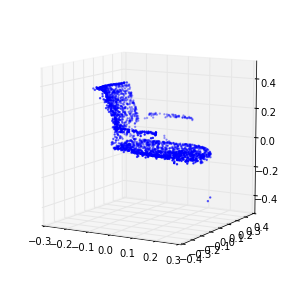

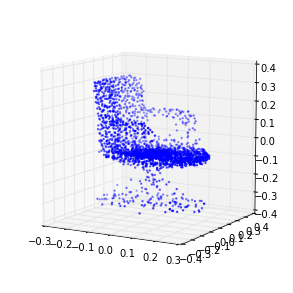

chair002


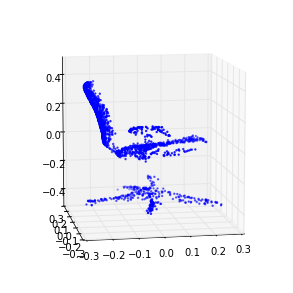

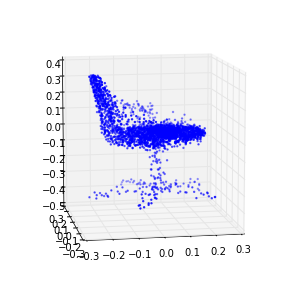

chair003


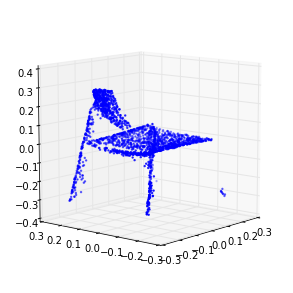

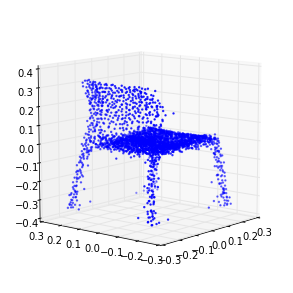

chair006


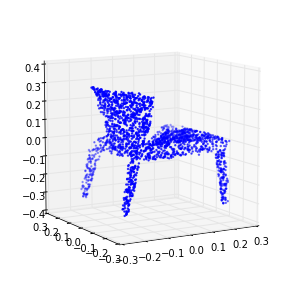

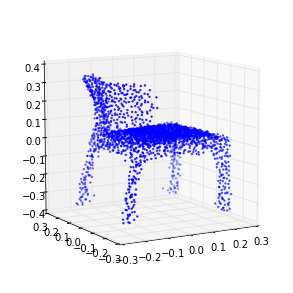

table002


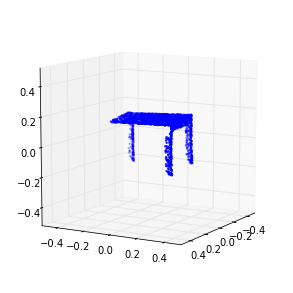

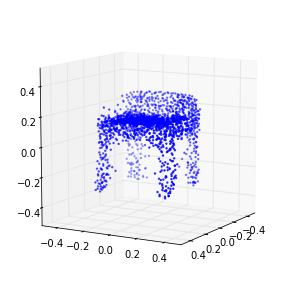

table004


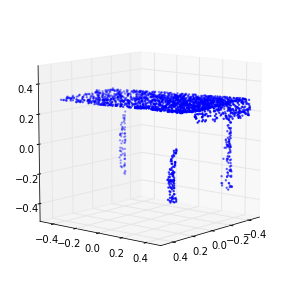

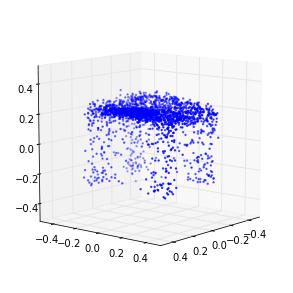

In [59]:
KinectData.plot_predictions(ae)